In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
from fastText import load_model
from matplotlib import pylab
from sklearn.manifold import TSNE

In [15]:
# Fasttext embeddings trained on train and val sets
# ./fasttext skipgram -input input_text_file -output output_model -dim 300 (fastText-0.1.0)
fasttext_model = load_model('word_vectors/fasttext_model.bin')
num_dims = 300

In [16]:
# vocab contains frequent words apperaing in the text along with their frequencies
# minimum frequency = 6
vocab_file = open('finished_files/vocab')
# Store appearing words
vocab_words = {}
for line in vocab_file:
    li = line.split()
    if len(li) == 2:
        word, freq = li
        vocab_words[word] = freq
# Final word to id dictionary    
word2id = {}
tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
for token in tokens:
    word2id[token] = len(word2id)
# Retrieve words from fasttext model and keep only those which are also present in 'vocab'
fasttext_words = fasttext_model.get_words()
for word in fasttext_words:
    if word in vocab_words:
        word2id[word] = len(word2id)        
vocab_size = len(word2id)
# Reverse dictionary
id2word = dict(zip(word2id.values(), word2id.keys()))
# Embeddings
embeddings = np.zeros((vocab_size, num_dims))
# <pad> token vector contains all zeros. Rest sampled from a normal distribution
mu, sigma = 0, 0.05
for i in range(1, len(tokens)):
    embeddings[i] = np.random.normal(mu, sigma, num_dims)
# Get word vectors from fasttext model and store in embeddings matrix
for i in range(len(tokens), vocab_size):
    embeddings[i] = fasttext_model.get_word_vector(id2word[i])
    
del fasttext_model, vocab_words

In [17]:
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embeddings[1:num_points+1, :])

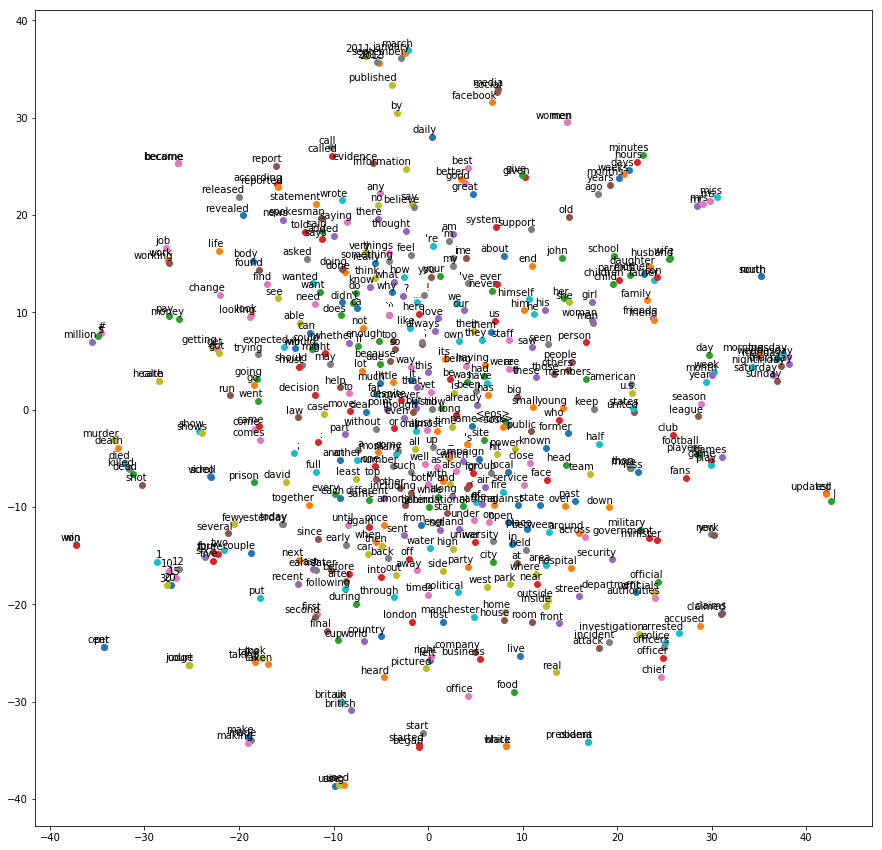

In [18]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [id2word[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [4]:
df = pd.read_csv('datasets/val.csv')

In [5]:
class Batch:
    def __init__(self):
        self.abstract = (None, None)
        self.article = (None, None)

In [33]:
max_article_size = 400
max_abstract_size = 100

class BatchGenerator: 
    
    def __init__(self, batch_size, dataframe):
        self.batch_size = batch_size
        # train, valid, or test dataframe imported from csv
        self.df = dataframe
        self.generator = self.row_generator()
        
        
    def row_generator(self):
        for row in self.df.itertuples(index=False):
            yield row
            
    def build_batch(self, rows):
        # If number of rows less than batch size, get extra rows from the beginning of the dataframe
        if len(rows) < self.batch_size:
            temp_generator = self.row_generator()
            for i in range(self.batch_size - len(rows)):
                rows.append(self.get_row(temp_generator))
        # Get lengths of all the sequences in the batch upto max number of tokens
        # + 1 is for the <eos> token
        abstract_lengths = torch.cuda.LongTensor(
            [len(row.abstract.split()[:max_abstract_size]) for row in rows]) + 1
        article_lengths = torch.cuda.LongTensor(
            [len(row.article.split()[:max_article_size]) for row in rows])
        abs_len = torch.max(abstract_lengths)
        art_len = torch.max(article_lengths) 
        # Variables containing abstracts and articles of the batch
        abstracts = torch.cuda.LongTensor(abs_len, self.batch_size).fill_(0) # zero padding
        articles = torch.cuda.LongTensor(art_len, self.batch_size).fill_(0) # zero padding
        for i in range(self.batch_size):
            # Tokenize abstract and take max_abstract_size number of tokens
            tokens = rows[i].abstract.split()[:max_abstract_size]
            tokens.append('<eos>')
            # Convert each token to word index
            # <unk> token index for unknown words
            token_list = torch.LongTensor([word2id[token] if token in word2id 
                                           else word2id['<unk>'] for token in tokens])
            # Store as column in abstracts variable with zero padding
            abstracts[:,i][:len(token_list)] = token_list
            # Same for articles
            tokens = rows[i].article.split()[:max_article_size]
            token_list = torch.LongTensor([word2id[token] if token in word2id 
                                           else word2id['<unk>'] for token in tokens])
            articles[:,i][:len(token_list)] = token_list
        batch = Batch()
        batch.article = (Variable(articles), article_lengths)
        batch.abstract = (Variable(abstracts), abstract_lengths)
        return batch
            
    def get_row(self, generator):
        row = generator.__next__()
        while not isinstance(row.article, str):
            row = generator.__next__()
        return row
        
        
    def get_batch(self):
        rows = []
        for b in range(self.batch_size):
            try: rows.append(self.get_row(self.generator))
            except StopIteration: break
        if rows: return self.build_batch(rows)
        else: raise StopIteration

In [34]:
bg = BatchGenerator(64, df)
batch = bg.get_batch()